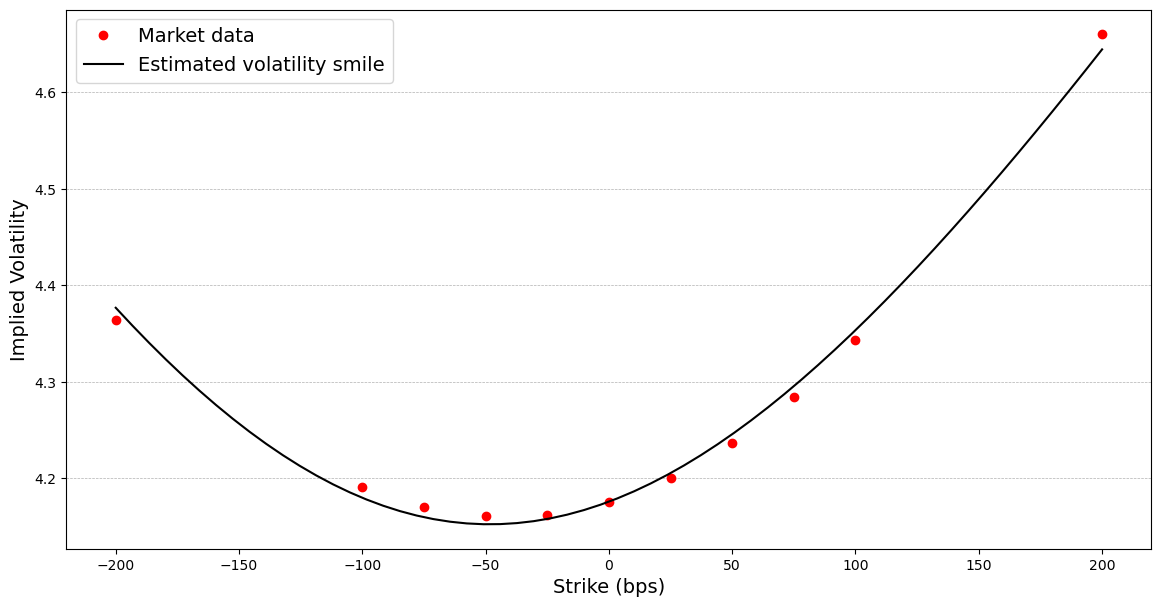

Results for 10Y30Y_est_beta_1.png: alpha=0.3867399125466862, nu=3.3960922108540723, rho=0.12213438030003133


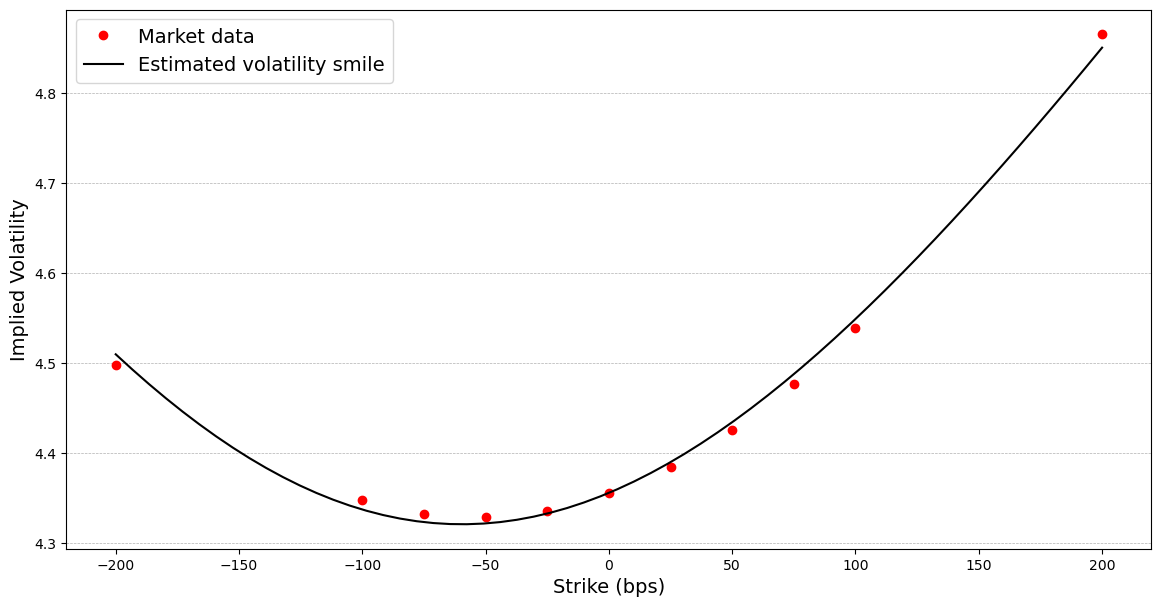

Results for 10Y20Y_est_beta_1.png: alpha=0.3838890122898514, nu=3.4955097116596434, rho=0.14564753122901966


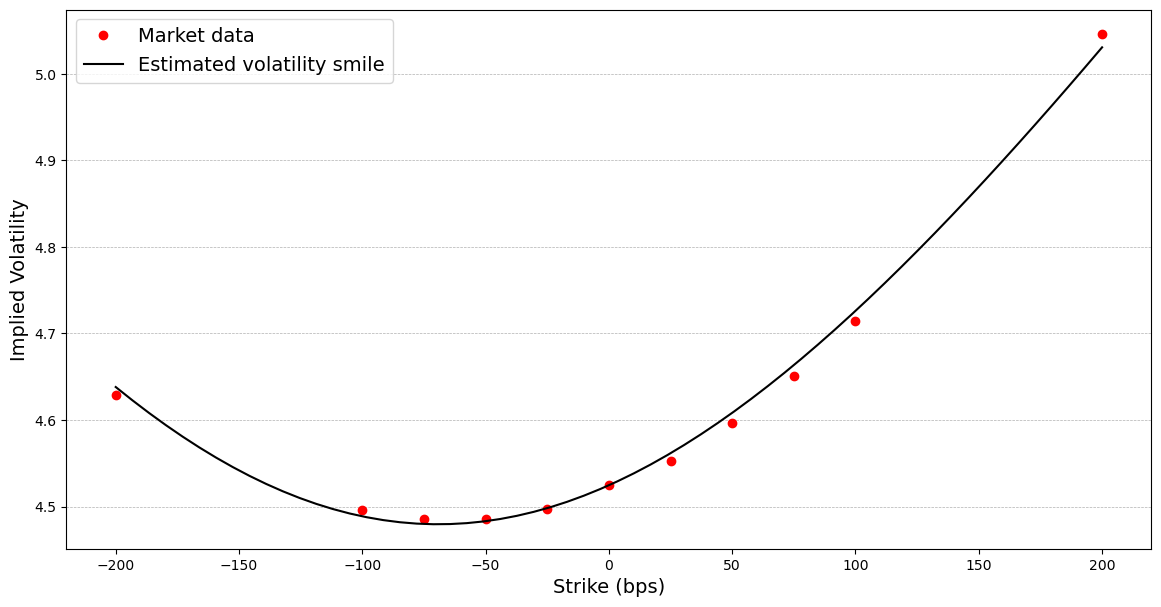

Results for 10Y15Y_est_beta_1.png: alpha=0.38658038358934166, nu=3.5603640023306213, rho=0.16238678034748633


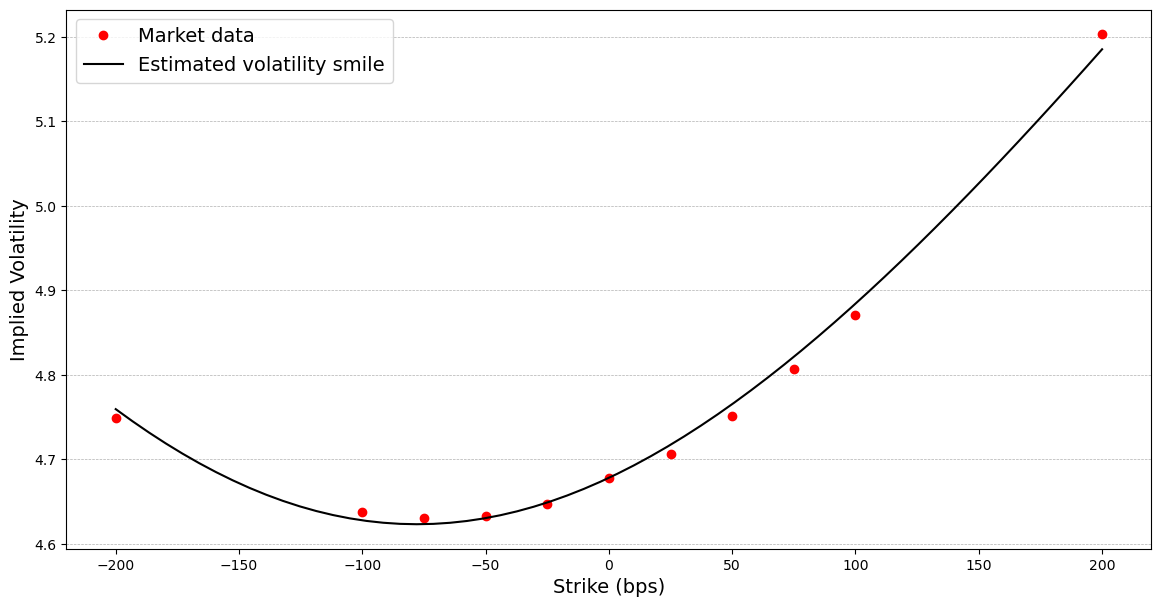

Results for 10Y12Y_est_beta_1.png: alpha=0.44203848484678815, nu=3.3525706014557333, rho=0.1762319802081651


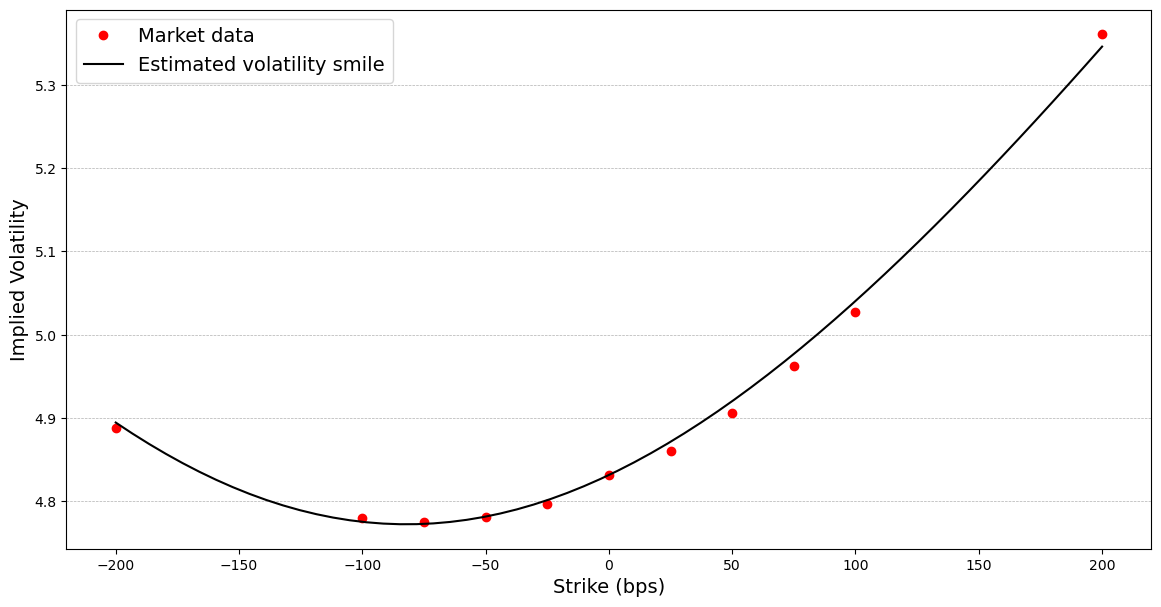

Results for 10Y10Y_est_beta_1.png: alpha=0.3962940617978688, nu=3.6463352136214446, rho=0.17994822033218683


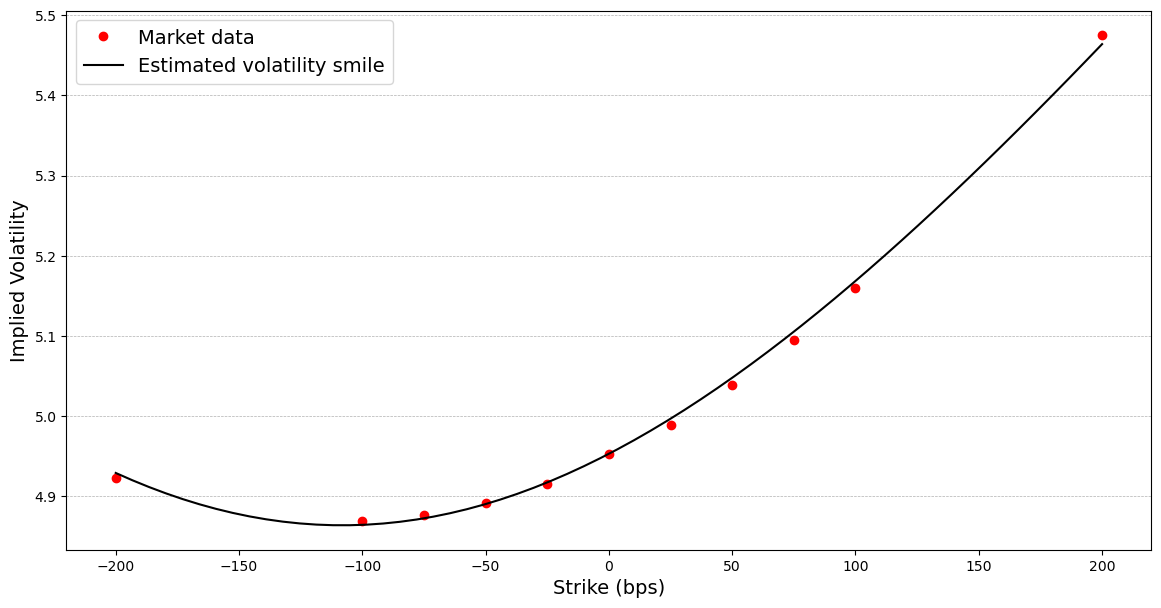

Results for 10Y7Y_est_beta_1.png: alpha=0.41532297835368914, nu=3.6137523051343705, rho=0.21769244368340604


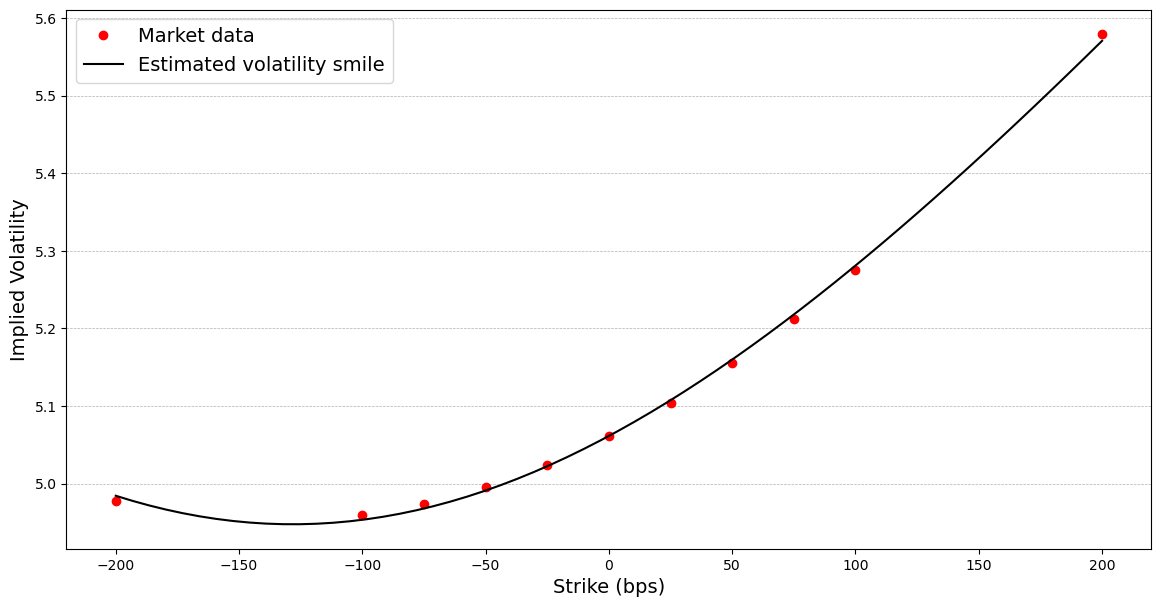

Results for 10Y5Y_est_beta_1.png: alpha=0.4320841853232329, nu=3.586963161885439, rho=0.24296641932686475


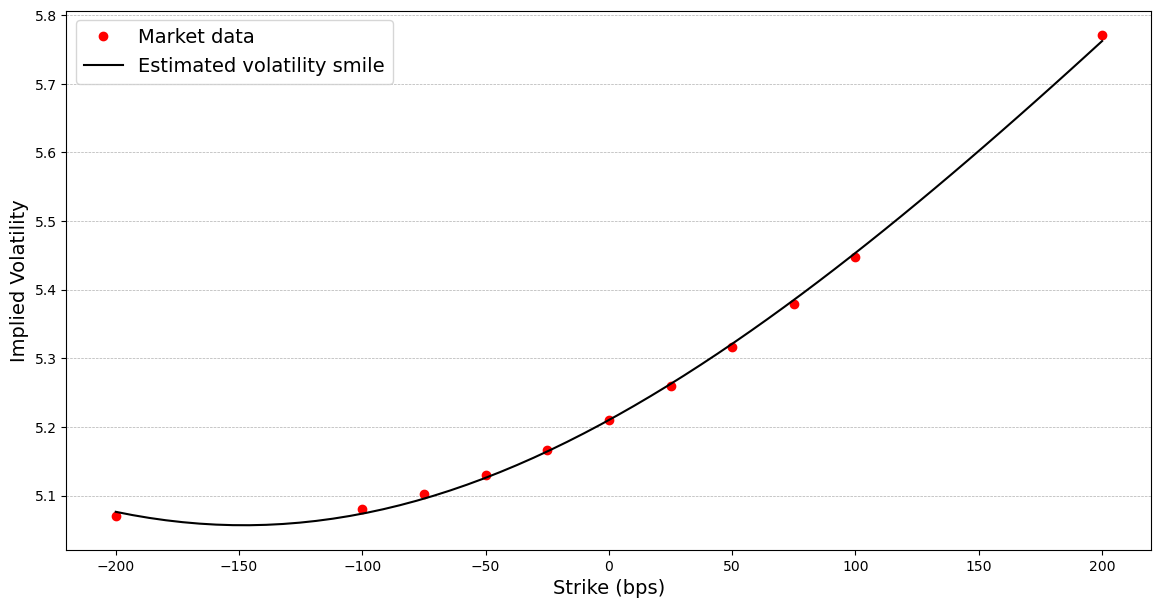

Results for 10Y3Y_est_beta_1.png: alpha=0.44261197036061456, nu=3.6199188523133308, rho=0.27725999333409995


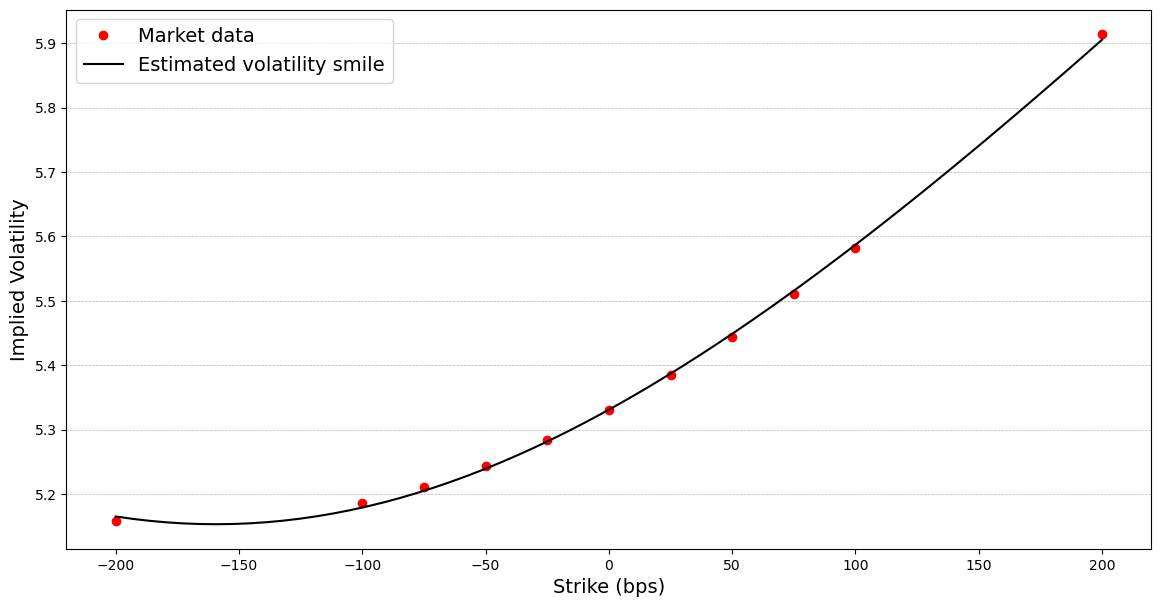

Results for 10Y2Y_est_beta_1.png: alpha=0.45353819595872963, nu=3.6284644477994754, rho=0.29472670271794776


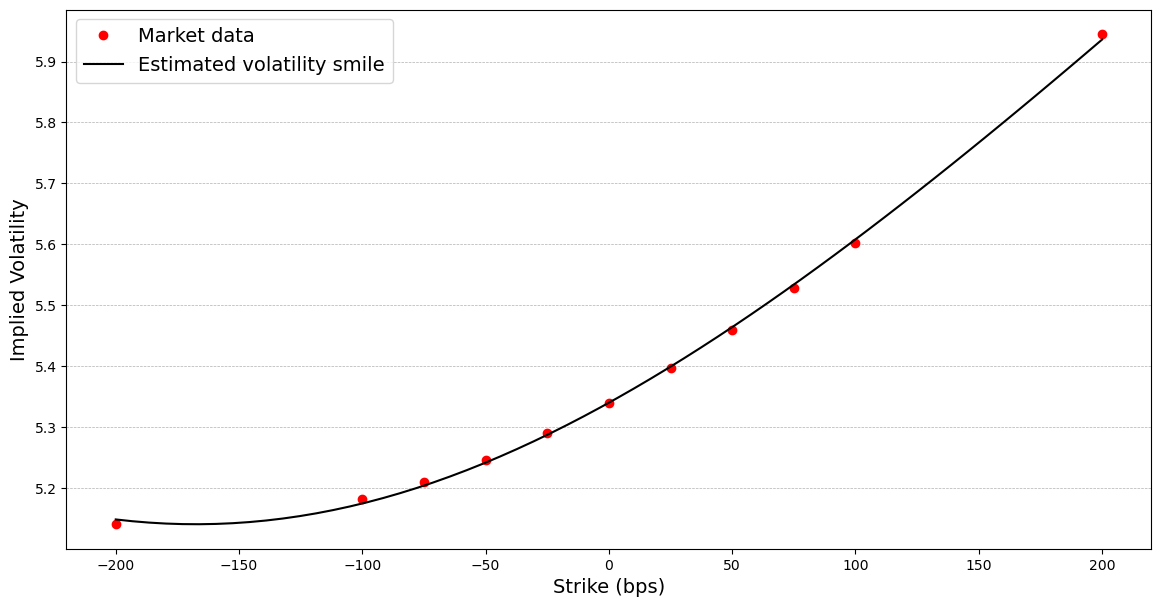

Results for 10Y1Y_est_beta_1.png: alpha=0.457700917319851, nu=3.628248717874738, rho=0.3114857588330078


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def SABR_market_vol(K, f, t_exp, alpha, beta, nu, rho):
    '''Returns the market volatility predicted by the SABR model for given strike prices and parameters.'''
    output = np.zeros(len(K))
    atm_idx = K == f
    non_atm_idx = K != f

    # ATM case
    part_1 = (1 - beta)**2 * alpha**2 / (24 * f**(2 - 2 * beta))
    part_2 = rho * beta * alpha * nu / (4 * f**(1 - beta))
    part_3 = (2 - 3 * rho**2) * nu**2 / 24
    output[atm_idx] = (alpha / f**(1 - beta)) * (1 + (part_1 + part_2 + part_3) * t_exp)

    # Non-ATM case
    logfK = np.log(f / K[non_atm_idx])
    fkbpow = (f * K[non_atm_idx])**((1 - beta) / 2)
    z = nu * fkbpow * logfK / alpha
    xz = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
    part_1 = ((1 - beta)**2 * alpha**2) / (24 * fkbpow**2)
    part_2 = (rho * beta * nu * alpha) / (4 * fkbpow)
    part_3 = (2 - 3 * rho**2) * nu**2 / 24
    part_4 = ((1 - beta)**2 * logfK**2) / 24
    part_5 = ((1 - beta)**4 * logfK**4) / 1920
    output[non_atm_idx] = (alpha * z * (1 + (part_1 + part_2 + part_3) * t_exp)) / (fkbpow * xz * (1 + part_4 + part_5))

    return output

def atm_sigma_to_alpha(f, t_exp, sigma_atm, beta, nu, rho):
    '''Calculates and returns alpha for given forward price, ATM volatility, time to expiry, and SABR parameters.'''
    coeffs = [
        (1 - beta)**2 * t_exp / (24 * f**(3 - 3 * beta)),
        rho * beta * nu * t_exp / (4 * f**(2 - 2 * beta)),
        (1 + (2 - 3 * rho**2) * nu**2 * t_exp / 24) / f**(1 - beta),
        -sigma_atm
    ]
    roots = np.roots(coeffs)
    alpha = roots[(roots.imag == 0) & (roots.real >= 0)].real.min()
    return alpha

def SABR_calibration(f, t_exp, sigma_atm, beta, strikes, vols, guess):
    '''Calibrates and returns alpha, nu, and rho for given forward price, ATM volatility, time to expiry, market volatilities, and strike prices.'''
    def volatility_smile(K, nu, rho):
        alpha = atm_sigma_to_alpha(f, t_exp, sigma_atm, beta, nu, rho)
        return SABR_market_vol(K, f, t_exp, alpha, beta, nu, rho)
    
    optimal_params, _ = curve_fit(volatility_smile, strikes, vols, p0=(guess[1], guess[2]), maxfev=10000)
    nu, rho = optimal_params
    alpha = atm_sigma_to_alpha(f, t_exp, sigma_atm, beta, nu, rho)
    
    return alpha, nu, rho

def plot_volatility_smile(strikes_in_bps, sigmas, Ks_in_bps, vols_from_Ks, folder, filename):
    '''Plots the market and estimated volatility smiles.'''
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    plt.figure(figsize=(14, 7))
    plt.plot(strikes_in_bps, sigmas, 'o', color='red', label='Market data')
    plt.plot(Ks_in_bps, vols_from_Ks, color='black', label='Estimated volatility smile')
    plt.xlabel("Strike (bps)", fontsize=14)
    plt.ylabel("Implied Volatility", fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.savefig(os.path.join(folder, filename))
    plt.show()
    plt.close()

def calibrate_and_plot(beta, sigmas, strikes_in_bps, t_exp, f, atm_sigma, folder, filename):
    strikes = f + strikes_in_bps * 0.0001
    guess = [0.01, 10, -0.5]
    alpha, nu, rho = SABR_calibration(f, t_exp, atm_sigma, beta, strikes, sigmas, guess)
    Ks_in_bps = np.linspace(-200, 200, 60)
    Ks = f + Ks_in_bps * 0.0001
    vols_from_Ks = SABR_market_vol(Ks, f, t_exp, alpha, beta, nu, rho)
    plot_volatility_smile(strikes_in_bps, sigmas, Ks_in_bps, vols_from_Ks, folder, filename)
    return alpha, nu, rho

# Calibration and plotting for different tenors
data = [
    (1, np.array([0.4364, 0.4191, 0.41706, 0.41605, 0.41619, 0.41757, 0.42003, 0.42370, 0.42847, 0.43428, 0.46603]) * 10, 0.23401, 0.41757 * 10, '10Y30Y_est_beta_1.png'),
    (1, np.array([0.44983, 0.43478, 0.43329, 0.43288, 0.43360, 0.43559, 0.43846, 0.44256, 0.44772, 0.45385, 0.48650]) * 10, 0.251744, 0.43559 * 10, '10Y20Y_est_beta_1.png'),
    (1, np.array([0.46292, 0.44963, 0.44859, 0.44862, 0.44974, 0.45247, 0.45530, 0.45970, 0.46509, 0.47143, 0.50457]) * 10, 0.265454, 0.45247 * 10, '10Y15Y_est_beta_1.png'),
    (1, np.array([0.47487, 0.46379, 0.46305, 0.46334, 0.46470, 0.46781, 0.47064, 0.47517, 0.48068, 0.48709, 0.52033]) * 10, 0.2276305, 0.46781 * 10, '10Y12Y_est_beta_1.png'),
    (1, np.array([0.48882, 0.47796, 0.47750, 0.47806, 0.47966, 0.48315, 0.48598, 0.49065, 0.49626, 0.50275, 0.53610]) * 10, 0.284018, 0.48315 * 10, '10Y10Y_est_beta_1.png'),
    (1, np.array([0.49234, 0.48694, 0.48762, 0.48916, 0.49157, 0.49531, 0.49896, 0.50388, 0.50955, 0.51594, 0.54749]) * 10, 0.294395, 0.49531 * 10, '10Y7Y_est_beta_1.png'),
    (1, np.array([0.49781, 0.49597, 0.49735, 0.49950, 0.50241, 0.50614, 0.51043, 0.51549, 0.52119, 0.52750, 0.55792]) * 10, 0.299258, 0.50614 * 10, '10Y5Y_est_beta_1.png'),
    (1, np.array([0.50699, 0.50806, 0.51017, 0.51304, 0.51665, 0.52101, 0.52599, 0.53166, 0.53795, 0.54480, 0.57709]) * 10, 0.299622, 0.52101 * 10, '10Y3Y_est_beta_1.png'),
    (1, np.array([0.51588, 0.51864, 0.52116, 0.52442, 0.52841, 0.53311, 0.53845, 0.54444, 0.55102, 0.55815, 0.59138]) * 10, 0.297602, 0.53311 * 10, '10Y2Y_est_beta_1.png'),
    (1, np.array([0.51416, 0.51819, 0.52105, 0.52465, 0.52898, 0.53399, 0.53966, 0.54596, 0.55283, 0.56025, 0.59448]) * 10, 0.293838, 0.53399 * 10, '10Y1Y_est_beta_1.png')
]

strikes_in_bps = np.array([-200, -100, -75, -50, -25, 0, 25, 50, 75, 100, 200])
t_exp = 10
plot_folder = "/Users/nannaingemannohrt/Desktop/master_thesis/main/plots"

for beta, sigmas, f, atm_sigma, filename in data:
    alpha, nu, rho = calibrate_and_plot(beta, sigmas, strikes_in_bps, t_exp, f, atm_sigma, plot_folder, filename)
    print(f"Results for {filename}: alpha={alpha}, nu={nu}, rho={rho}")
